In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 1.7.0  Device: cuda


In [3]:
train_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                     train = True,
                                     download = True,
                                     transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "./data/FashionMNIST",
                                    train = False,
                                    transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

In [4]:
for(X_train, Y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('Y_train:', Y_train.size(), 'type:', Y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor


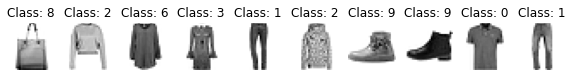

In [5]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(Y_train[i].item()))

In [6]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256,32),)
        
        self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28 * 28),)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [8]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image),
                                                                               len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28* 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to('cpu'))
            gen_image.append(image.to('cpu'))
    
    test_loss /= len(test_loader.dataset)
    
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.185082
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.029613
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.023685
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.019277
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.019530
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.017392
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.018402
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.017245
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.015817
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.015946

[EPOCH: 1], 	Test Loss: 0.0005


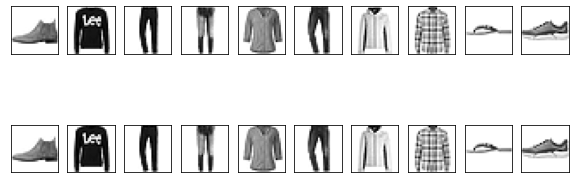

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.013952
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.013772
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.012861
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.014624
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.014869
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.015152
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.014786
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.012181
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.013782
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.011726

[EPOCH: 2], 	Test Loss: 0.0004


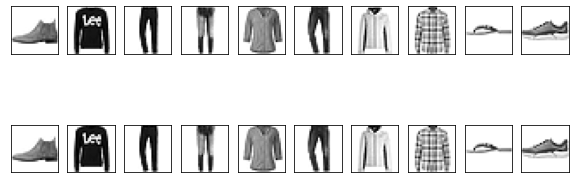

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.011779
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.012619
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.014414
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.014161
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.011324
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.011495
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.013624
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.011551
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.010665
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.015288

[EPOCH: 3], 	Test Loss: 0.0004


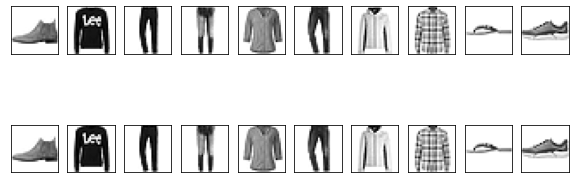

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.011144
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.011803
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.012081
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.010990
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.012907
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.012879
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.013059
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.011074
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.013301
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.012467

[EPOCH: 4], 	Test Loss: 0.0004


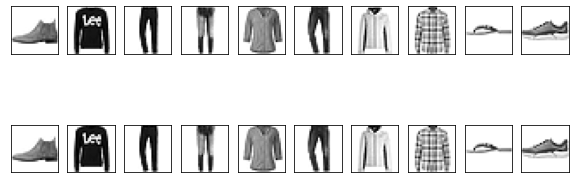

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.011568
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.009578
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.011079
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.010652
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.009753
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.011271
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.011015
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.009850
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.009168
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.011468

[EPOCH: 5], 	Test Loss: 0.0003


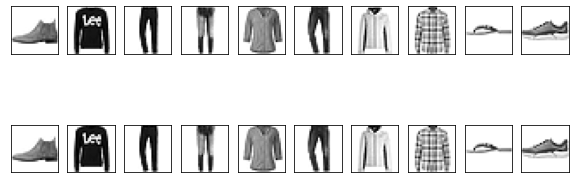

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.010398
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.009642
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.011044
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.010656
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.012727
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.013392
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.009027
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.012976
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.009249
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.015115

[EPOCH: 6], 	Test Loss: 0.0003


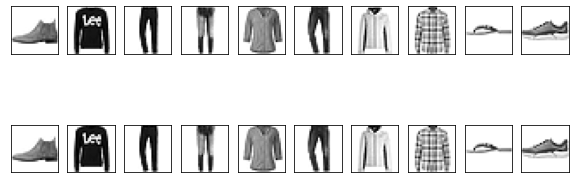

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.011178
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.010375
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.012495
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.010900
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.010164
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.009385
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.010709
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.011475
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.011290
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.009949

[EPOCH: 7], 	Test Loss: 0.0003


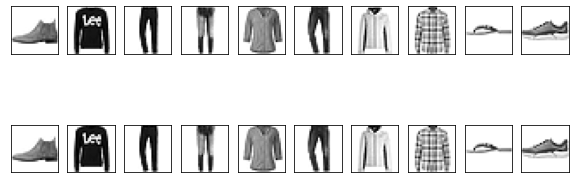

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.011018
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.007725
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.011573
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.013081
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.012249
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.009036
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.007795
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.010968
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.009478
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.009278

[EPOCH: 8], 	Test Loss: 0.0003


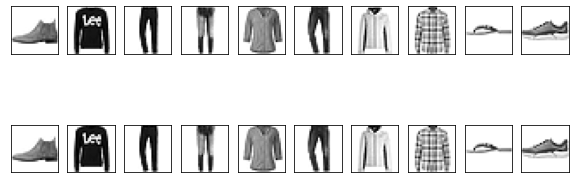

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.007515
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.012610
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.009029
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.011516
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.013767
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.010160
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.009646
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.009771
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.009318
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.009764

[EPOCH: 9], 	Test Loss: 0.0003


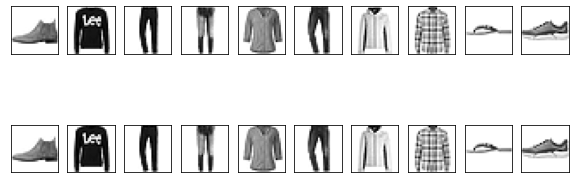

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.009913
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.010794
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.009131
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.010813
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.007279
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.010695
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.009294
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.011242
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.011057
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.009339

[EPOCH: 10], 	Test Loss: 0.0003


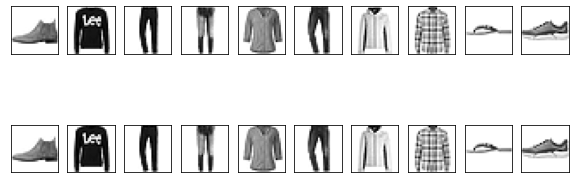

In [10]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    
    for i in range(10):
        img = np.reshape(real_image[0][i],(28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[0][i],(28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()